In [25]:
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np

Brown (2019): https://github.com/IrinaStatsLab/Awesome-CGM/wiki/Brown-(2019)

Quick statistics:

* 168 patients
* no. of recorded events by patient vary from 36,220 to 57,756
* the date range across all patients is from 4.08.2016 to 25.03.2019
* continuous recorded periods for each patient vary from 183 to 204 days with one exeption where one patient had 846 days worth of recorded events

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
file_path = '/content/drive/My Drive/masinope/project/merette_experiments/cgm.txt'
dclp3 = pd.read_csv(file_path, sep="|")

In [28]:
#dclp3 = pd.read_csv("C:/Users/meril/Desktop/Projekt_ML/DCLP3/Data Files/cgm.txt", sep="|")

In [29]:
dclp3.head(10)

,PtID,Period,DataDtTm,CGM
0,1,1. Baseline,11DEC17:23:59:25,172
1,1,1. Baseline,12DEC17:00:04:24,170
2,1,1. Baseline,12DEC17:00:09:24,167
3,1,1. Baseline,12DEC17:00:14:25,163
4,1,1. Baseline,12DEC17:00:19:25,160
5,1,1. Baseline,12DEC17:00:24:24,158
6,1,1. Baseline,12DEC17:00:29:25,157
7,1,1. Baseline,12DEC17:00:34:25,155
8,1,1. Baseline,12DEC17:00:39:24,154
9,1,1. Baseline,12DEC17:00:44:25,153


In [30]:
len(dclp3) # 9 032 235

9032235

In [31]:
dclp3['PtID'].value_counts() # sorted in descending order by COUNTS

,count
PtID,
119,57756
22,57656
3,57599
169,57555
145,57548
...,...
45,46170
82,46006
9,44932


In [32]:
dclp3['PtID'].value_counts().sort_index() # sorted in increasing order by PATIENT ID

,count
PtID,
1,57016
2,53537
3,57599
4,48805
5,57151
...,...
167,55273
168,56066
169,57555


In [33]:
len(dclp3['PtID'].unique()) # 168 patients

168

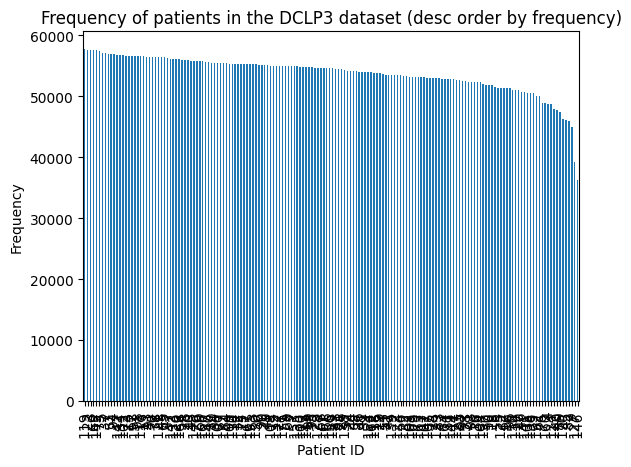

In [34]:
dclp3['PtID'].value_counts().plot(kind='bar')
plt.xlabel('Patient ID')
plt.ylabel('Frequency')
plt.title('Frequency of patients in the DCLP3 dataset (desc order by frequency)')
plt.show()

In [ ]:
# Format dates from string to datetime
dclp3['DataDtTm'] = pd.to_datetime(dclp3['DataDtTm'], format='%d%b%y:%H:%M:%S')

In [ ]:
dclp3.head()

In [ ]:
# Hendriku koodi algus

In [ ]:
#2 kategooriaga lahenduse algus

In [ ]:
# Convert mg/dL → mmol/L, because those are the units our supervisor gave us while giving an overview of the topic
dclp3['CGM_mmol'] = dclp3['CGM'] / 18

# Create a column to check if the value of CGM is between 4–10 mmol/L
dclp3['in_range'] = dclp3['CGM_mmol'].between(4, 10)

# Classify by the CGM_mmol is it in range, hypoglycemia, or hyperglycemia
def classify_glucose(val): # in mmol/L
    if val < 4.0:
        return 'hypoglycemia'
    elif val <= 10:
        return 'in_range'
    else:
        return 'hyperglycemia'

dclp3['CGM_category'] = dclp3['CGM_mmol'].apply(classify_glucose)

In [ ]:
# Assuming dclp3 already loaded
#df = dclp3.copy()
df = dclp3

# Sort by patient and timestamp
df = df.sort_values(["PtID", "DataDtTm"])

# Feature engineering
df["CGM_diff"] = df.groupby("PtID")["CGM_mmol"].diff()
df["rolling_mean"] = df.groupby("PtID")["CGM_mmol"].transform(lambda x: x.rolling(6, min_periods=1).mean())
df["rolling_std"] = df.groupby("PtID")["CGM_mmol"].transform(lambda x: x.rolling(6, min_periods=1).std())
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# Target: whether glucose is trending abnormal (high or low)
df["trend_flag"] = ((df["CGM_mmol"] > 10) | (df["CGM_mmol"] < 4)).astype(int)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Drop non-feature columns
features = ["CGM_mmol", "CGM_diff", "rolling_mean", "rolling_std", "hour_sin", "hour_cos"]
X = df[features]
y = df["trend_flag"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train model
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
model.fit(X_train, y_train)

# Predict and evaluate (optional for doctor’s background info)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


In [ ]:
# Predict on entire dataset
df["risk_pred"] = model.predict(X)

# Summarize per patient and period
summary = (
    df.groupby(["PtID", "Period"])
    .agg(
        avg_glucose=("CGM_mmol", "mean"),
        abnormal_readings=("risk_pred", "sum"),
        total_readings=("CGM_mmol", "count"),
        time_in_range=("in_range", "mean"),
    )
    .reset_index()
)

summary["risk_ratio"] = summary["abnormal_readings"] / summary["total_readings"]
summary["recommendation"] = np.where(
    summary["risk_ratio"] > 0.3,
    "Review insulin settings / dietary pattern",
    "Stable — continue monitoring",
)


In [ ]:
for pid, group in summary.groupby("PtID"):
    print(f"Patient {pid}")
    print(group[["Period", "avg_glucose", "risk_ratio", "recommendation"]])
    print("-" * 40)


In [ ]:
#2 kategooriaga lahenduse lõpp

In [ ]:
import pandas as pd
import numpy as np

# Assume `dclp3` already loaded and has columns:
# ['PtID', 'Period', 'CGM_mmol', 'hour', 'risk_pred']

# --- Aggregate features per patient and period ---
summary = (
    df.groupby(["PtID", "Period"])
    .agg(
        avg_glucose=("CGM_mmol", "mean"),
        risk_ratio=("risk_pred", "mean"),
        pct_hypo=("CGM_mmol", lambda x: (x < 4).mean()),         # <70 mg/dL
        pct_hyper=("CGM_mmol", lambda x: (x > 13.9).mean()),     # >250 mg/dL
        nocturnal_high=("CGM_mmol",
                        lambda x: x[(df.loc[x.index, "hour"].between(0, 6))].gt(10).mean()),
        postprandial_spikes=("CGM_mmol",
                             lambda x: ((x - x.shift(1)) > 2).mean()),
        variability=("CGM_mmol", "std"),
        total_readings=("CGM_mmol", "count"),
    )
    .reset_index()
)

# --- Rule-based clinical recommendations ---
def clinical_recommendation(row):
    # 1. Urgent review for hypoglycemia
    if row["pct_hypo"] >= 0.03:
        return "Urgent review — high hypoglycemia risk"

    # 2. Escalate to clinic for persistent severe hyperglycemia
    if row["avg_glucose"] > 11 or row["pct_hyper"] > 0.20:
        return "Escalate to clinic / medication change"

    # 3. Basal adjustment (night-time highs)
    if row["nocturnal_high"] > 0.25:
        return "Adjust basal rates / background insulin"

    # 4. Bolus/carb ratio adjustment (spikes after meals)
    if row["postprandial_spikes"] > 0.15 and row["avg_glucose"] > 8.5:
        return "Adjust bolus / carb ratio"

    # 5. Pump algorithm / mode change
    if row["risk_ratio"] > 0.35 and row["avg_glucose"] > 9:
        return "Consider pump algorithm / mode change"

    # 6. Education/dietitian referral (erratic patterns)
    if row["variability"] > 3.0 and row["risk_ratio"] < 0.3:
        return "Refer to education / dietitian"

    # 7. Review insulin/diet (moderate risk)
    if row["risk_ratio"] > 0.25 or row["avg_glucose"] >= 9:
        return "Review insulin settings / dietary pattern"

    # 8. Stable
    return "Stable — continue monitoring"

# Apply to all rows
summary["recommendation"] = summary.apply(clinical_recommendation, axis=1)

# --- Example output per patient ---
for pid, group in summary.groupby("PtID"):
    print(f"Patient {pid}")
    print(group[[
        "Period", "avg_glucose", "risk_ratio",
        "pct_hypo", "pct_hyper", "variability", "recommendation"
    ]])
    print("-" * 50)


In [ ]:
# 8 kategooriaga lahenduse algus

In [ ]:
#8 kategooriaga lahenduse lõpp

In [ ]:
#Hendriku koodi lõpp